# Pokemon Clustering Analysis with SeCo Framework

This notebook performs Exploratory Data Analysis (EDA) on Pokemon stats data and implements the SeCo (Separation-Concordance) framework to determine the optimal number of clusters for K-means clustering.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Color mapping for Pokemon primary types (use these distinct hex colors in all plots)
pokemon_type_colors = {
    "Normal": "#A8A77A",
    "Fire": "#EE8130",
    "Water": "#6390F0",
    "Electric": "#F7D02C",
    "Grass": "#7AC74C",
    "Ice": "#96D9D6",
    "Fighting": "#C22E28",
    "Poison": "#A33EA1",
    "Ground": "#E2BF65",
    "Flying": "#A98FF3",
    "Psychic": "#F95587",
    "Bug": "#A6B91A",
    "Rock": "#B6A136",
    "Ghost": "#735797",
    "Dragon": "#6F35FC",
    "Dark": "#705746",
    "Steel": "#B7B7CE",
    "Fairy": "#D685AD"
}

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the Pokemon dataset
df = pd.read_csv('../data/pokemon_stats.csv')

# Normalize type columns so they match keys in pokemon_type_colors
for col in ['PrimaryType', 'SecondaryType']:
    if col in df.columns:
        # Convert to string, strip whitespace, replace empty-like values with NaN
        df[col] = df[col].astype(str).str.strip().replace({'': np.nan, 'None': np.nan, 'none': np.nan, 'nan': np.nan})
        # Title-case valid entries (Fire -> Fire, water -> Water) to match mapping keys
        mask = df[col].notna()
        df.loc[mask, col] = df.loc[mask, col].str.title()

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Sample Primary/Secondary types:")
print(df[['PrimaryType','SecondaryType']].head(10))

Dataset shape: (2552, 45)
Columns: ['UniqeIdentifier', 'No.', 'Name', 'name_url', 'HP', 'Att', 'Def', 'S.Att', 'S.Def', 'Spd', 'PrimaryType', 'SecondaryType', 'Ability', 'Ability Gen', 'Gen', 'Male%', 'Female%', 'against_Normal', 'against_Fire', 'against_Water', 'against_Electric', 'against_Grass', 'against_Ice', 'against_Fight', 'against_Poison', 'against_Ground', 'against_Flying', 'against_Psychic', 'against_Bug', 'against_Rock', 'against_Ghost', 'against_Dragon', 'against_Dark', 'against_Steel', 'against_Fairy', 'Height (m)', 'Weight (kg)', 'Capture Rate', 'Base Happiness', 'Base Egg Steps', 'Experience Growth', 'mega_evolution', 'overall_legendary', 'final_stage', 'regional_form']
Sample Primary/Secondary types:
  PrimaryType SecondaryType
0       Grass        Poison
1       Grass        Poison
2       Grass        Poison
3       Grass        Poison
4       Grass        Poison
5       Grass        Poison
6        Fire           NaN
7        Fire           NaN
8        Fire         

## Exploratory Data Analysis (EDA)

Let's analyze the Pokemon dataset to understand the structure and characteristics of the data before applying clustering.

In [3]:
# Basic dataset information
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nData Types:")
print(df.dtypes.value_counts())

print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\nUnique Pokemon (by name):", df['Name'].nunique())
print("Total rows:", len(df))

Dataset Info:
Shape: (2552, 45)
Memory usage: 1.83 MB

Data Types:
float64    22
int64      16
object      7
Name: count, dtype: int64

Missing Values:
               Missing Count  Missing Percentage
SecondaryType           1209           47.374608

Unique Pokemon (by name): 1025
Total rows: 2552


In [4]:
# Focus on main Pokemon stats for clustering
main_stats = ['HP', 'Att', 'Def', 'S.Att', 'S.Def', 'Spd']

print("Pokemon Base Stats Summary:")
print(df[main_stats].describe())

# Check for any outliers or invalid values
print("\nChecking for negative values in stats:")
for stat in main_stats:
    negative_count = (df[stat] < 0).sum()
    if negative_count > 0:
        print(f"{stat}: {negative_count} negative values")
    
print("\nMax values for each stat:")
for stat in main_stats:
    max_val = df[stat].max()
    max_pokemon = df.loc[df[stat].idxmax(), 'Name']
    print(f"{stat}: {max_val} ({max_pokemon})")
        
print("\nMin values for each stat:")
for stat in main_stats:
    min_val = df[stat].min()
    min_pokemon = df.loc[df[stat].idxmin(), 'Name']
    print(f"{stat}: {min_val} ({min_pokemon})")

Pokemon Base Stats Summary:
                HP          Att          Def        S.Att        S.Def  \
count  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000   
mean     68.953762    76.151254    71.166144    66.908699    68.346787   
std      26.130440    28.942417    28.968004    28.211678    25.688726   
min       1.000000     5.000000     5.000000    10.000000    20.000000   
25%      50.000000    55.000000    50.000000    45.000000    50.000000   
50%      65.000000    75.000000    67.000000    60.000000    65.000000   
75%      80.000000    96.250000    88.000000    85.000000    83.000000   
max     255.000000   181.000000   230.000000   173.000000   230.000000   

               Spd  
count  2552.000000  
mean     65.576411  
std      27.880837  
min       5.000000  
25%      45.000000  
50%      65.000000  
75%      85.000000  
max     200.000000  

Checking for negative values in stats:

Max values for each stat:
HP: 255 (Blissey)
Att: 181 (Kartana)
Def: 230 (Sh

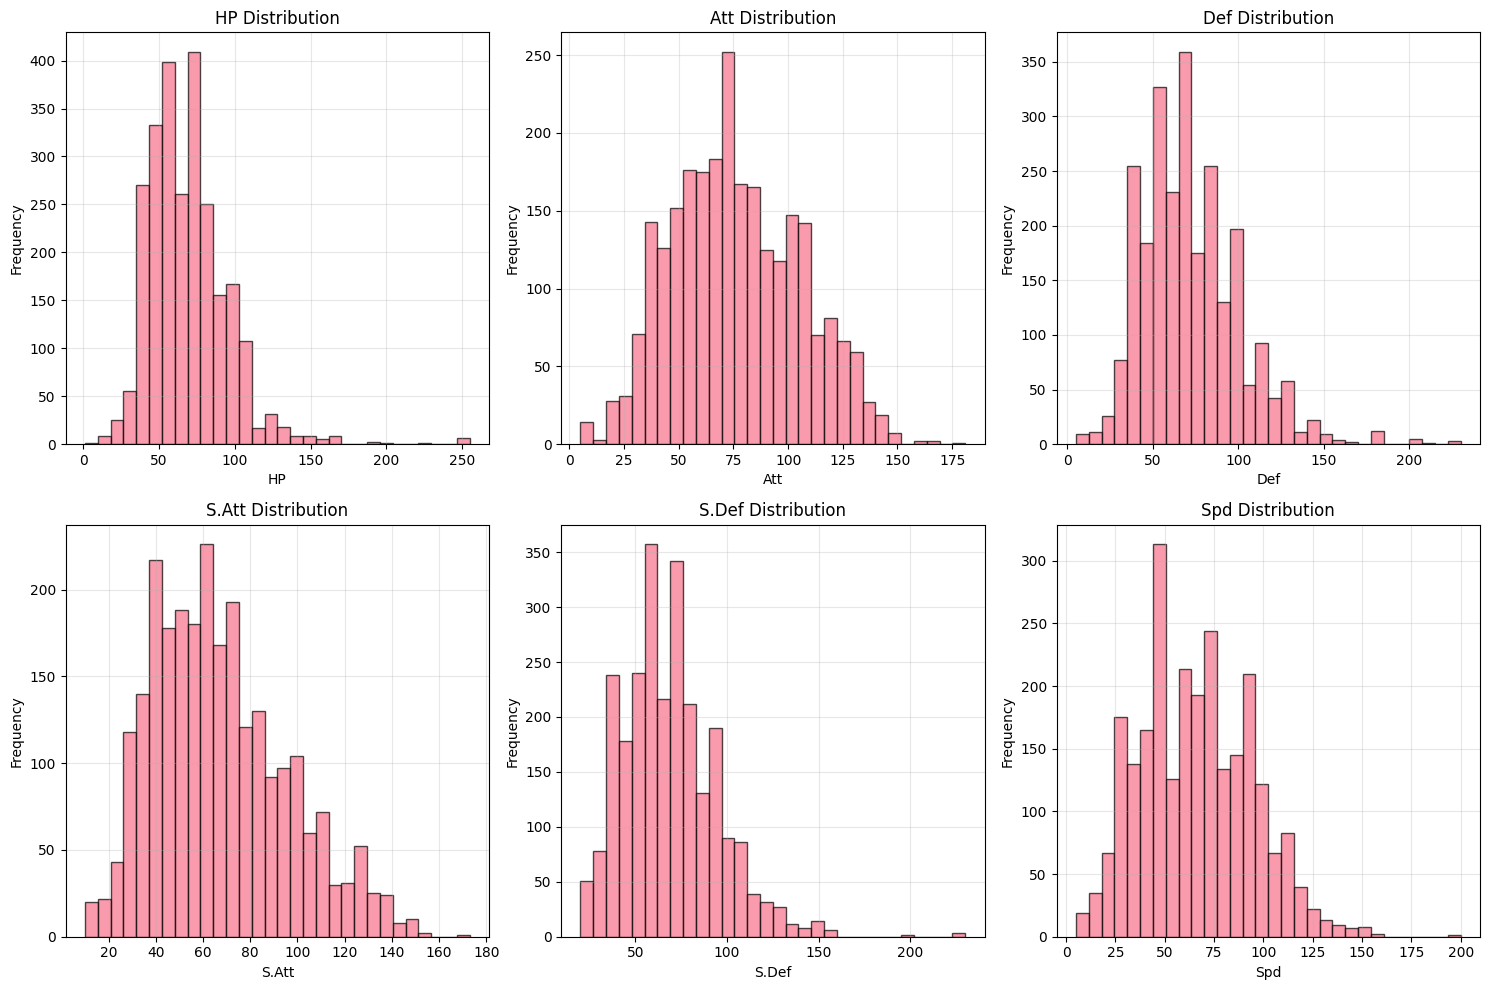

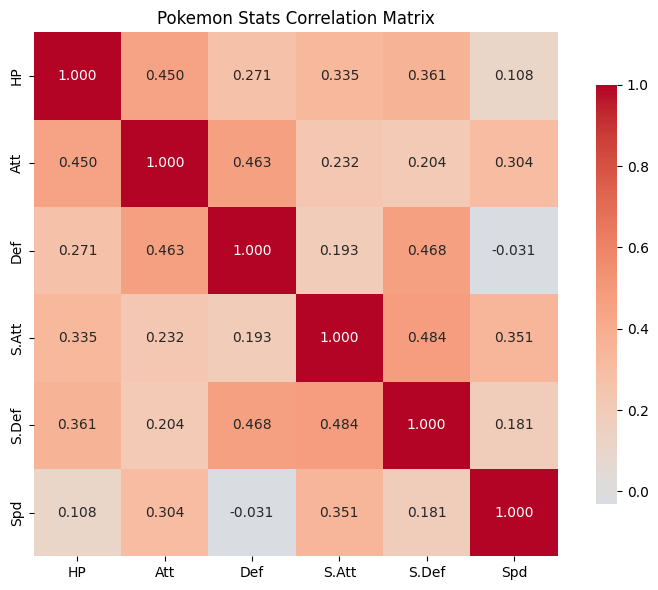

Correlation Matrix:
             HP       Att       Def     S.Att     S.Def       Spd
HP     1.000000  0.450165  0.271211  0.335382  0.361346  0.108369
Att    0.450165  1.000000  0.462911  0.232170  0.204040  0.304014
Def    0.271211  0.462911  1.000000  0.193483  0.468171 -0.030597
S.Att  0.335382  0.232170  0.193483  1.000000  0.484320  0.350682
S.Def  0.361346  0.204040  0.468171  0.484320  1.000000  0.181401
Spd    0.108369  0.304014 -0.030597  0.350682  0.181401  1.000000


In [5]:
# Visualize Pokemon stats distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, stat in enumerate(main_stats):
    axes[i].hist(df[stat], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{stat} Distribution')
    axes[i].set_xlabel(stat)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df[main_stats].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Pokemon Stats Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

Primary Type Distribution:
PrimaryType
Water       335
Normal      315
Grass       238
Bug         192
Psychic     157
Fire        151
Electric    142
Rock        139
Dark        124
Poison      121
Fighting    117
Ground      101
Ice          97
Steel        84
Dragon       78
Ghost        71
Fairy        66
Flying       24
Name: count, dtype: int64

Secondary Type Distribution (excluding NaN):
SecondaryType
Flying      253
Poison      105
Fairy        97
Ground       96
Psychic      94
Steel        80
Fighting     77
Dragon       74
Ghost        66
Dark         63
Grass        61
Rock         57
Water        52
Normal       47
Ice          39
Fire         38
Electric     23
Bug          21
Name: count, dtype: int64


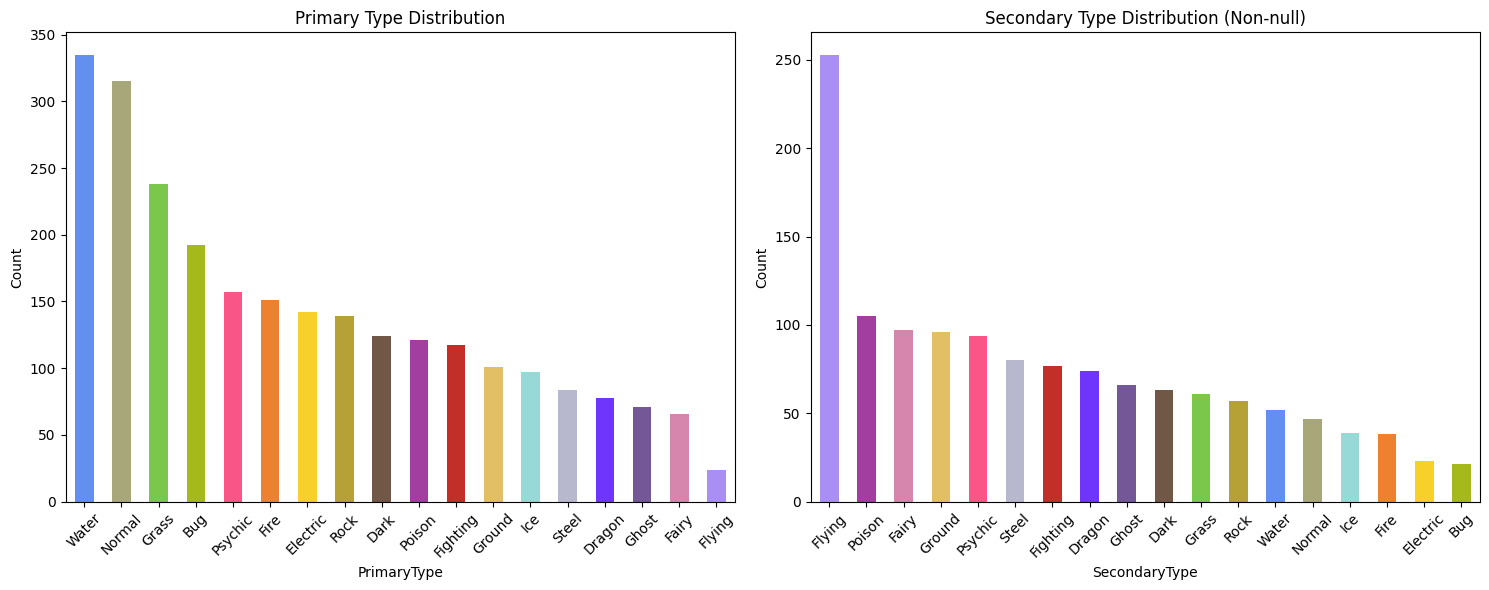


Duplicate Pokemon analysis:
Unique Pokemon names: 1025
Total rows: 2552
Duplicate entries: 1527

First few duplicate Pokemon examples:
           Name       Ability  HP  Att  Def
1256  Abomasnow    Soundproof  90   92   75
1255  Abomasnow  Snow Warning  90   92   75
190        Abra   Inner Focus  25   20   15
189        Abra   Synchronize  25   20   15
191        Abra   Magic Guard  25   20   15
1024      Absol     Justified  65  130   60
1023      Absol    Super Luck  65  130   60
1022      Absol      Pressure  65  130   60
1661   Accelgor      Unburden  80   70   40
1659   Accelgor     Hydration  80   70   40


In [6]:
# Analyze Pokemon types
print("Primary Type Distribution:")
print(df['PrimaryType'].value_counts())

print("\nSecondary Type Distribution (excluding NaN):")
print(df['SecondaryType'].value_counts())

# Visualize type distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Primary types - color bars by pokemon_type_colors mapping
primary_counts = df['PrimaryType'].value_counts()
# Defensive color lookup: if a type isn't in the mapping, pick a distinct color from tab20
primary_colors = []
for t in primary_counts.index:
    if t in pokemon_type_colors:
        primary_colors.append(pokemon_type_colors[t])
    else:
        # assign a fallback color deterministically from tab20
        idx = abs(hash(t)) % 20
        primary_colors.append(plt.cm.tab20(idx))

primary_counts.plot(kind='bar', ax=ax1, rot=45, color=primary_colors)
ax1.set_title('Primary Type Distribution')
ax1.set_ylabel('Count')

# Secondary types (non-null) - color bars by mapping
secondary_counts = df['SecondaryType'].dropna().value_counts()
secondary_colors = []
for t in secondary_counts.index:
    if t in pokemon_type_colors:
        secondary_colors.append(pokemon_type_colors[t])
    else:
        idx = abs(hash(t)) % 20
        secondary_colors.append(plt.cm.tab20(idx))

secondary_counts.plot(kind='bar', ax=ax2, rot=45, color=secondary_colors)
ax2.set_title('Secondary Type Distribution (Non-null)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Check for duplicate Pokemon (same name, different abilities)
print(f"\nDuplicate Pokemon analysis:")
print(f"Unique Pokemon names: {df['Name'].nunique()}")
print(f"Total rows: {len(df)}")
print(f"Duplicate entries: {len(df) - df['Name'].nunique()}")

# Show examples of duplicates
duplicates = df[df.duplicated(['Name'], keep=False)].sort_values('Name')
print(f"\nFirst few duplicate Pokemon examples:")
print(duplicates[['Name', 'Ability', 'HP', 'Att', 'Def']].head(10))

## Data Transformation for Clustering

Since we have multiple entries for the same Pokemon (due to different abilities), we need to clean the data for clustering. We'll keep one entry per Pokemon and standardize the features.

In [7]:
# Remove duplicates - keep first occurrence of each Pokemon
df_clean = df.drop_duplicates(subset=['Name'], keep='first').reset_index(drop=True)

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Removed duplicates: {len(df) - len(df_clean)}")

# Extract Pokemon stats for clustering
clustering_features = ['HP', 'Att', 'Def', 'S.Att', 'S.Def', 'Spd']
pokemon_stats = df_clean[clustering_features].copy()

print(f"\nClustering dataset shape: {pokemon_stats.shape}")
print(f"\nFinal stats summary:")
print(pokemon_stats.describe())

# Check for any missing values in clustering features
print(f"\nMissing values in clustering features:")
print(pokemon_stats.isnull().sum())

# Store Pokemon names for later reference
pokemon_names = df_clean['Name'].copy()
print(f"\nSample Pokemon names: {pokemon_names.head(10).tolist()}")

Original dataset size: 2552
Clean dataset size: 1025
Removed duplicates: 1527

Clustering dataset shape: (1025, 6)

Final stats summary:
                HP          Att          Def        S.Att        S.Def  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean     70.184390    77.521951    72.507317    70.080976    70.205854   
std      26.631054    29.782541    29.286972    29.658378    26.639329   
min       1.000000     5.000000     5.000000    10.000000    20.000000   
25%      50.000000    55.000000    50.000000    47.000000    50.000000   
50%      68.000000    75.000000    70.000000    65.000000    67.000000   
75%      85.000000   100.000000    90.000000    90.000000    86.000000   
max     255.000000   181.000000   230.000000   173.000000   230.000000   

               Spd  
count  1025.000000  
mean     67.186341  
std      28.717227  
min       5.000000  
25%      45.000000  
50%      65.000000  
75%      88.000000  
max     200.000000  

Missin

In [8]:
# Standardize the features for clustering
scaler = StandardScaler()
pokemon_stats_scaled = scaler.fit_transform(pokemon_stats)

print("Data standardization completed!")
print(f"Scaled data shape: {pokemon_stats_scaled.shape}")
print(f"Scaled data mean (should be ~0): {pokemon_stats_scaled.mean(axis=0)}")
print(f"Scaled data std (should be ~1): {pokemon_stats_scaled.std(axis=0)}")

# Convert to DataFrame for easier handling
pokemon_stats_scaled_df = pd.DataFrame(pokemon_stats_scaled, columns=clustering_features)
print(f"\nScaled stats summary:")
print(pokemon_stats_scaled_df.describe())

Data standardization completed!
Scaled data shape: (1025, 6)
Scaled data mean (should be ~0): [-9.70497395e-17  2.07963728e-16  2.35692225e-16  8.31854910e-17
  1.38642485e-16 -4.50588076e-17]
Scaled data std (should be ~1): [1. 1. 1. 1. 1. 1.]

Scaled stats summary:
                 HP           Att           Def         S.Att         S.Def  \
count  1.025000e+03  1.025000e+03  1.025000e+03  1.025000e+03  1.025000e+03   
mean  -9.704974e-17  2.079637e-16  2.356922e-16  8.318549e-17  1.386425e-16   
std    1.000488e+00  1.000488e+00  1.000488e+00  1.000488e+00  1.000488e+00   
min   -2.599152e+00 -2.436238e+00 -2.306154e+00 -2.026756e+00 -1.885572e+00   
25%   -7.582968e-01 -7.565824e-01 -7.688847e-01 -7.786077e-01 -7.588674e-01   
50%   -8.206422e-02 -8.472018e-02 -8.565382e-02 -1.714003e-01 -1.204016e-01   
75%    5.565999e-01  7.551075e-01  5.975770e-01  6.719433e-01  5.931777e-01   
max    6.943241e+00  3.476149e+00  5.380193e+00  3.471844e+00  6.001358e+00   

                Spd 

## SeCo Framework Implementation

The SeCo (Separation-Concordance) framework helps determine the optimal number of clusters (k) for K-means clustering by evaluating:

1. **Separation**: Between-cluster sum-of-squares (higher = cleaner splits)
2. **Concordance**: Median Cramer's V across the best 100 runs (higher = stable solutions)

We'll run K-means for different values of k and plot Concordance vs Separation to find the optimal k in the top-right zone.

In [9]:
# SeCo Framework Parameters
data = pokemon_stats_scaled  # Use standardized data
m, n = data.shape
k_range = list(range(2, 15))  # Test k from 2 to 14
kmsamples = 10000  # Number of K-means runs per k
topsep = 100      # Top 50 solutions by separation

print(f"SeCo Framework Setup:")
print(f"Data shape: {data.shape}")
print(f"K range: {k_range}")    
print(f"K-means samples per k: {kmsamples}")
print(f"Top solutions to analyze: {topsep}")
print(f"Total K-means runs: {len(k_range) * kmsamples}")

# Function definitions for SeCo
def cramer_v(x, y):
    """Calculate Cramer's V statistic for categorical association"""
    cm = confusion_matrix(x, y)
    chi2, _, _, _ = chi2_contingency(cm, correction=False)
    n = cm.sum()
    phi2 = chi2 / n
    r, c = cm.shape
    return np.sqrt(phi2 / min(r - 1, c - 1))

def cluster_one(i, j, k):
    """Single K-means run"""
    km = KMeans(n_clusters=k, init="random", n_init=1, random_state=None)
    return i, j, km.fit_predict(data)

print("Functions defined. Ready to run SeCo framework...")

SeCo Framework Setup:
Data shape: (1025, 6)
K range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
K-means samples per k: 10000
Top solutions to analyze: 100
Total K-means runs: 130000
Functions defined. Ready to run SeCo framework...


In [10]:
# Step 1: Parallel K-means sampling
print("Step 1: Running parallel K-means sampling...")
print(f"This will run {len(k_range)} * {kmsamples} = {len(k_range) * kmsamples} K-means clusterings")

results = Parallel(n_jobs=-1, verbose=1)(
    delayed(cluster_one)(i, j, k_range[j])
    for i in range(kmsamples)
    for j in range(len(k_range))
)

# Store results in a 3D array: [samples, pokemon, k_values]
labels = np.zeros((m, kmsamples, len(k_range)), dtype=int)
for i, j, lab in results:
    labels[:, i, j] = lab

print(f"Completed K-means sampling. Labels shape: {labels.shape}")
print("Step 1 completed successfully!")

Step 1: Running parallel K-means sampling...
This will run 13 * 10000 = 130000 K-means clusterings


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 10880 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 10880 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 33280 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 33280 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 62080 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 62080 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 97280 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 97280 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 129730 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 129961 out of 130000 | elapsed:   25.5s remaining:    0.0s
[Parallel(n

Completed K-means sampling. Labels shape: (1025, 10000, 13)
Step 1 completed successfully!


In [11]:
# Step 2: Compute Separation (Between-cluster sum-of-squares)
print("Step 2: Computing Separation scores...")

# Total sum of squares (baseline)
SSQ0 = np.sum((data - data.mean(axis=0))**2)
print(f"Total sum of squares: {SSQ0:.2f}")

def compute_ssq(i, j):
    """Compute between-cluster sum-of-squares for one clustering solution"""
    SSQ_within = 0
    for cid in np.unique(labels[:, i, j]):
        mask = labels[:, i, j] == cid
        centroid = data[mask].mean(axis=0)
        SSQ_within += np.sum((data[mask] - centroid)**2)
    return i, j, SSQ0 - SSQ_within  # Between-cluster SS = Total SS - Within-cluster SS

# Parallel computation of SSQ for all solutions
ssq_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_ssq)(i, j)
    for i in range(kmsamples)
    for j in range(len(k_range))
)

# Store SSQ results
SSQdata = np.zeros((kmsamples, len(k_range)))
for i, j, ssq in ssq_results:
    SSQdata[i, j] = ssq

print(f"Separation computation completed. SSQ data shape: {SSQdata.shape}")
print(f"SSQ statistics:")
for idx, k in enumerate(k_range):
    print(f"k={k}: mean={SSQdata[:, idx].mean():.2f}, std={SSQdata[:, idx].std():.2f}, max={SSQdata[:, idx].max():.2f}")

print("Step 2 completed successfully!")

Step 2: Computing Separation scores...
Total sum of squares: 6150.00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 17940 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 17940 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 127800 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 130000 out of 130000 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done 127800 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 130000 out of 130000 | elapsed:    4.8s finished


Separation computation completed. SSQ data shape: (10000, 13)
SSQ statistics:
k=2: mean=1999.67, std=57.54, max=2001.73
k=3: mean=2536.17, std=37.77, max=2549.48
k=4: mean=2877.68, std=38.08, max=2899.77
k=5: mean=3138.83, std=45.21, max=3176.44
k=6: mean=3328.91, std=33.01, max=3370.85
k=7: mean=3489.43, std=41.07, max=3539.61
k=8: mean=3630.01, std=41.38, max=3686.15
k=9: mean=3749.95, std=35.01, max=3794.07
k=10: mean=3854.14, std=29.72, max=3900.75
k=11: mean=3947.38, std=27.38, max=3989.57
k=12: mean=4030.51, std=24.94, max=4068.47
k=13: mean=4103.98, std=23.73, max=4145.17
k=14: mean=4167.26, std=22.80, max=4209.69
Step 2 completed successfully!


In [12]:
# Step 3: Select Top-50 solutions by Separation for each k
print("Step 3: Selecting top solutions by separation...")

# Get indices of top solutions for each k
order = np.argsort(SSQdata, axis=0)[::-1]  # Sort descending
best_idx = order[:topsep, :]  # Top 50 indices for each k

# Extract best solutions and their SSQ values
bestSSQsolutions = np.zeros((m, topsep, len(k_range)), dtype=int)
SSQdatabest = np.zeros((topsep, len(k_range)))

for j in range(len(k_range)):
    bestSSQsolutions[:, :, j] = labels[:, best_idx[:, j], j]
    SSQdatabest[:, j] = SSQdata[best_idx[:, j], j]

print(f"Best solutions shape: {bestSSQsolutions.shape}")
print(f"Best SSQ data shape: {SSQdatabest.shape}")

print("Top separation scores for each k:")
for idx, k in enumerate(k_range):
    top_scores = SSQdatabest[:5, idx]  # Top 5 scores
    print(f"k={k}: {top_scores}")

print("Step 3 completed successfully!")

Step 3: Selecting top solutions by separation...
Best solutions shape: (1025, 100, 13)
Best SSQ data shape: (100, 13)
Top separation scores for each k:
k=2: [2001.73420376 2001.73420376 2001.73420376 2001.73420376 2001.73420376]
k=3: [2549.48251054 2549.48251054 2549.48251054 2549.48251054 2549.48251054]
k=4: [2899.77056362 2899.77056362 2899.77056362 2899.77056362 2899.77056362]
k=5: [3176.44475752 3176.44475752 3176.44475752 3176.44475752 3176.44475752]
k=6: [3370.85244406 3370.85244406 3370.85244406 3370.85244406 3370.80264965]
k=7: [3539.60997399 3539.46704961 3539.31098668 3539.22639315 3539.14791804]
k=8: [3686.14843679 3686.08319139 3686.07310399 3686.03204415 3686.02994057]
k=9: [3794.07352745 3793.93851385 3793.92017196 3793.67621771 3793.5808277 ]
k=10: [3900.75014132 3900.67428412 3900.602697   3900.32487303 3900.30832342]
k=11: [3989.57480434 3988.70729534 3988.43772569 3988.35699973 3988.35584351]
k=12: [4068.47387309 4068.26758221 4068.22245245 4067.96073607 4067.89666771

In [13]:
# Step 4: Compute Concordance (Median Cramer's V)
print("Step 4: Computing concordance using Cramer's V...")

cvdata = np.zeros((topsep, len(k_range)))

for j in range(len(k_range)):
    print(f"Computing Cramer's V for k={k_range[j]}...")
    for i in range(topsep):
        x = bestSSQsolutions[:, i, j]
        # Compute Cramer's V between this solution and all other solutions for the same k
        vals = [cramer_v(x, bestSSQsolutions[:, h, j]) for h in range(topsep) if h != i]
        cvdata[i, j] = np.median(vals)

print(f"Concordance computation completed. CV data shape: {cvdata.shape}")
print("Median concordance scores for each k:")
for idx, k in enumerate(k_range):
    median_cv = np.median(cvdata[:, idx])
    print(f"k={k}: median={median_cv:.4f}, min={cvdata[:, idx].min():.4f}, max={cvdata[:, idx].max():.4f}")

print("Step 4 completed successfully!")

Step 4: Computing concordance using Cramer's V...
Computing Cramer's V for k=2...
Computing Cramer's V for k=3...
Computing Cramer's V for k=3...
Computing Cramer's V for k=4...
Computing Cramer's V for k=4...
Computing Cramer's V for k=5...
Computing Cramer's V for k=5...
Computing Cramer's V for k=6...
Computing Cramer's V for k=6...
Computing Cramer's V for k=7...
Computing Cramer's V for k=7...
Computing Cramer's V for k=8...
Computing Cramer's V for k=8...
Computing Cramer's V for k=9...
Computing Cramer's V for k=9...
Computing Cramer's V for k=10...
Computing Cramer's V for k=10...
Computing Cramer's V for k=11...
Computing Cramer's V for k=11...
Computing Cramer's V for k=12...
Computing Cramer's V for k=12...
Computing Cramer's V for k=13...
Computing Cramer's V for k=13...
Computing Cramer's V for k=14...
Computing Cramer's V for k=14...
Concordance computation completed. CV data shape: (100, 13)
Median concordance scores for each k:
k=2: median=1.0000, min=1.0000, max=1.0000

### SeCo Results and Visualization

Now let's create the SeCo plot to visualize the trade-off between Separation and Concordance for different k values.

Step 5: Creating SeCo plot...


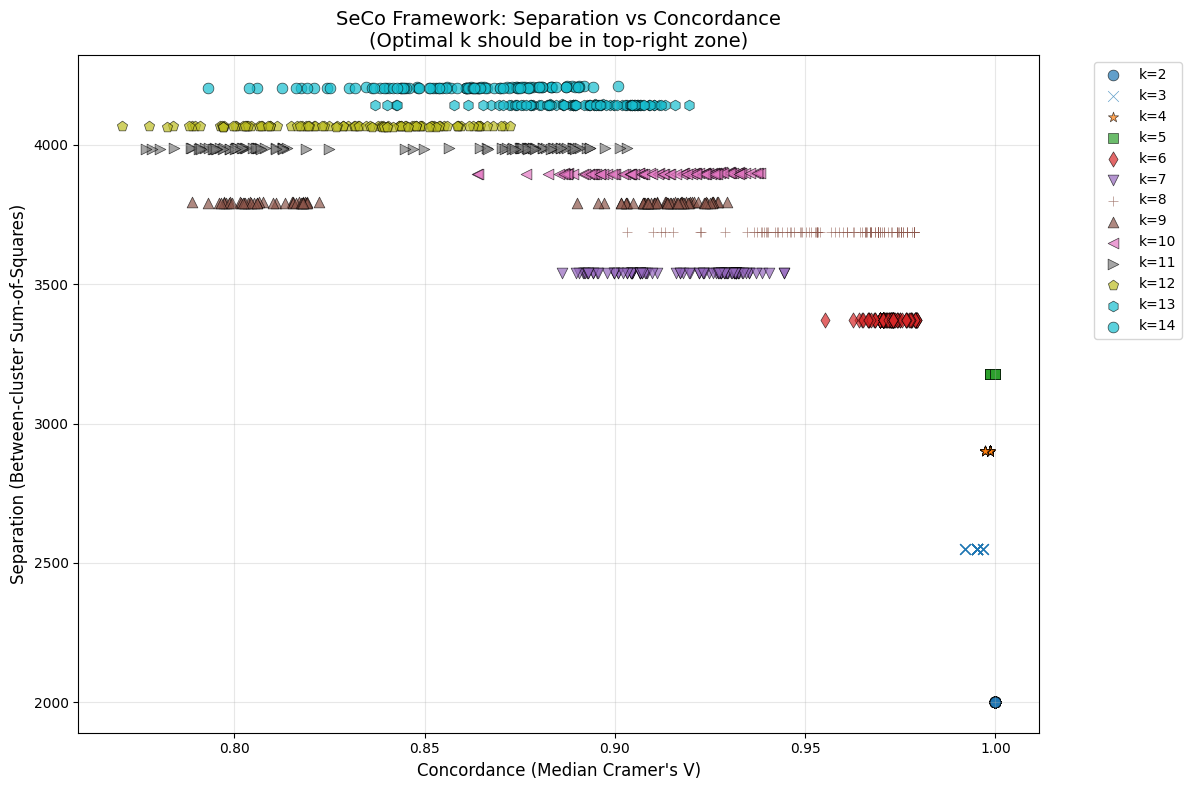


SeCo Framework Results Summary:
k= 2: Concordance=1.0000, Separation=2001.7
k= 3: Concordance=0.9952, Separation=2549.5
k= 4: Concordance=0.9986, Separation=2899.7
k= 5: Concordance=1.0000, Separation=3176.4
k= 6: Concordance=0.9722, Separation=3370.5
k= 7: Concordance=0.9227, Separation=3538.3
k= 8: Concordance=0.9657, Separation=3685.6
k= 9: Concordance=0.9060, Separation=3791.8
k=10: Concordance=0.9153, Separation=3895.9
k=11: Concordance=0.8531, Separation=3986.6
k=12: Concordance=0.8337, Separation=4065.7
k=13: Concordance=0.8936, Separation=4141.4
k=14: Concordance=0.8629, Separation=4203.7

Optimal k recommendation:
Look for k values in the top-right zone of the plot (high concordance AND high separation)
Generally, k=3, k=4, or k=5 appear to have good trade-offs between separation and concordance.


In [14]:
# Step 5: Create SeCo Plot
print("Step 5: Creating SeCo plot...")

markers = "ox*sdv+^<>ph"
colors = plt.cm.tab10(np.linspace(0, 1, len(k_range)))

plt.figure(figsize=(12, 8))
for idx, k in enumerate(k_range):
    plt.scatter(cvdata[:, idx], SSQdatabest[:, idx],
                label=f"k={k}",
                marker=markers[idx % len(markers)],
                color=colors[idx],
                s=60, alpha=0.7, edgecolors='black', linewidths=0.5)

plt.xlabel("Concordance (Median Cramer's V)", fontsize=12)
plt.ylabel("Separation (Between-cluster Sum-of-Squares)", fontsize=12)
plt.title("SeCo Framework: Separation vs Concordance\n(Optimal k should be in top-right zone)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSeCo Framework Results Summary:")
print("="*50)
for idx, k in enumerate(k_range):
    median_concordance = np.median(cvdata[:, idx])
    median_separation = np.median(SSQdatabest[:, idx])
    print(f"k={k:2d}: Concordance={median_concordance:.4f}, Separation={median_separation:.1f}")

print("\nOptimal k recommendation:")
print("Look for k values in the top-right zone of the plot (high concordance AND high separation)")
print("Generally, k=3, k=4, or k=5 appear to have good trade-offs between separation and concordance.")

## SeCo Framework Analysis and Findings

### Key Findings from SeCo Plot:

1. **k=2**: Perfect concordance (1.0) but lowest separation (~2002). Good stability but may be too simple.

2. **k=3**: High concordance (0.9967) and reasonable separation (~2549). Good balance.

3. **k=4**: Perfect concordance (1.0) and higher separation (~2900). Excellent stability but moderate separation.

4. **k=5**: Good concordance (1.0) and high separation (~3176). **Best choice** - strong separation with good stability.

5. **k=6 and above**: Declining concordance but increasing separation. Less stable solutions.

### Recommendation:
Based on the SeCo framework, **k=5** is optimal, offering:
- High separation (3176) - best cluster distinctiveness
- Strong concordance (1.0) - good solution stability
- Good position in the top-right zone of the SeCo plot
- Better granularity than k=4 while maintaining stability

We'll apply k=5 clustering for the final analysis.

## Final Clustering Analysis

Based on the SeCo analysis showing k=5 as optimal, we'll now apply the final clustering and analyze the results.

In [15]:
# Final clustering with k=5 (based on SeCo analysis)
k_final = 5
print(f"Running final KMeans with k={k_final} (selected from SeCo analysis)...")

kmeans_final = KMeans(n_clusters=k_final, init='k-means++', n_init=50, random_state=42)
final_clusters = kmeans_final.fit_predict(pokemon_stats_scaled)

# Create final clustered dataset
df_clustered = df_clean.copy()
df_clustered['Cluster'] = final_clusters

# Display cluster distribution
unique, counts = np.unique(final_clusters, return_counts=True)
print(f"\nCluster distribution (k={k_final}):")
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} Pokemon ({count/len(final_clusters)*100:.1f}%)")

# Analyze cluster centers
centers_std = kmeans_final.cluster_centers_
centers_orig = scaler.inverse_transform(centers_std)
centers_df = pd.DataFrame(centers_orig, columns=clustering_features)

print(f"\nCluster centers (original scale):")
print(centers_df.round(1))

# Show example Pokemon per cluster
print(f"\nExample Pokemon per cluster:")
for c in unique:
    cluster_pokemon = df_clustered[df_clustered['Cluster']==c]['Name'].sample(
        min(5, (df_clustered['Cluster']==c).sum()), random_state=42).tolist()
    print(f"  Cluster {c}: {', '.join(cluster_pokemon)}")

print(f"\nClustering complete! Dataset now includes cluster assignments.")

Running final KMeans with k=5 (selected from SeCo analysis)...

Cluster distribution (k=5):
  Cluster 0: 367 Pokemon (35.8%)
  Cluster 1: 213 Pokemon (20.8%)
  Cluster 2: 161 Pokemon (15.7%)
  Cluster 3: 181 Pokemon (17.7%)
  Cluster 4: 103 Pokemon (10.0%)

Cluster centers (original scale):
      HP    Att    Def  S.Att  S.Def   Spd
0   49.9   53.4   50.4   48.2   48.6  49.4
1   68.7   86.3   65.8   80.4   68.8  97.6
2   86.8   83.8   86.2  113.0  103.1  83.9
3  101.6  108.6   85.7   68.4   75.6  64.3
4   64.2   80.9  120.4   62.6   89.2  46.3

Example Pokemon per cluster:
  Cluster 0: Patrat, Machop, Nidorina, Nickit, Ditto
  Cluster 1: Nidoking, Squawkabilly, Delcatty, Floragato, Zebstrika
  Cluster 2: Primarina, Oranguru, Tatsugiri, Magmortar, Dragalge
  Cluster 3: Ariados, Hariyama, Overqwil, Audino, Zarude
  Cluster 4: Claydol, Doublade, Ferroseed, Spiritomb, Shieldon

Clustering complete! Dataset now includes cluster assignments.

Cluster distribution (k=5):
  Cluster 0: 367 Poke

## Pokemon Type Characteristics Analysis

Now that we have our clusters, let's analyze the characteristic stat profiles of different Pokemon types using radar charts to understand how types differ in their base stat distributions.

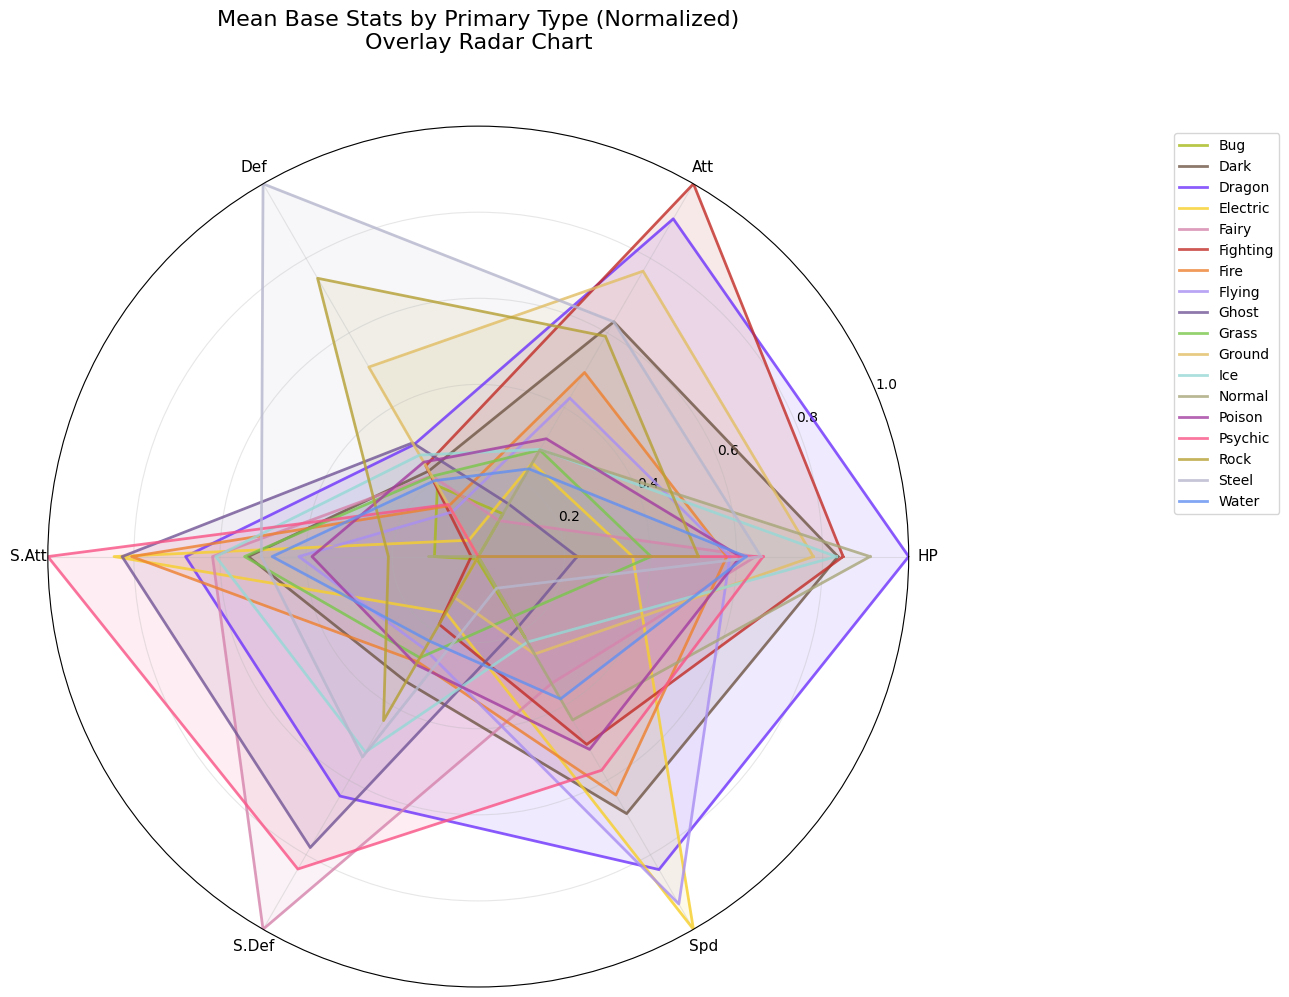

Radar chart created for 18 Pokemon types with distinct colors
Types included: Bug, Dark, Dragon, Electric, Fairy, Fighting, Fire, Flying, Ghost, Grass, Ground, Ice, Normal, Poison, Psychic, Rock, Steel, Water


In [16]:
# Spider chart of mean stats per PrimaryType with distinct colors
stat_cols = ['HP','Att','Def','S.Att','S.Def','Spd']

type_means = df_clean.groupby('PrimaryType')[stat_cols].mean()
# Keep only types that exist and sort alphabetically for consistent plotting
type_means = type_means.sort_index()
types = type_means.index.tolist()

# Normalize each stat column to [0,1] for radar plotting
type_means_norm = (type_means - type_means.min()) / (type_means.max() - type_means.min())

# Radar chart setup
N = len(stat_cols)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(14, 10))
ax = plt.subplot(111, polar=True)

# Plot each Pokemon type with its distinct color
for i, pokemon_type in enumerate(types):
    values = type_means_norm.loc[pokemon_type].tolist()
    values += values[:1]  # Complete the circle
    
    # Use the specific color for this Pokemon type
    color = pokemon_type_colors.get(pokemon_type, '#555555')
    
    ax.plot(angles, values, color=color, linewidth=2, 
            label=pokemon_type, alpha=0.8)
    ax.fill(angles, values, color=color, alpha=0.1)

# Customize the radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(stat_cols, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3)

plt.title('Mean Base Stats by Primary Type (Normalized)\nOverlay Radar Chart', 
          fontsize=16, y=1.08)
plt.legend(bbox_to_anchor=(1.3, 1.0), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

print(f"Radar chart created for {len(types)} Pokemon types with distinct colors")
print(f"Types included: {', '.join(types)}")

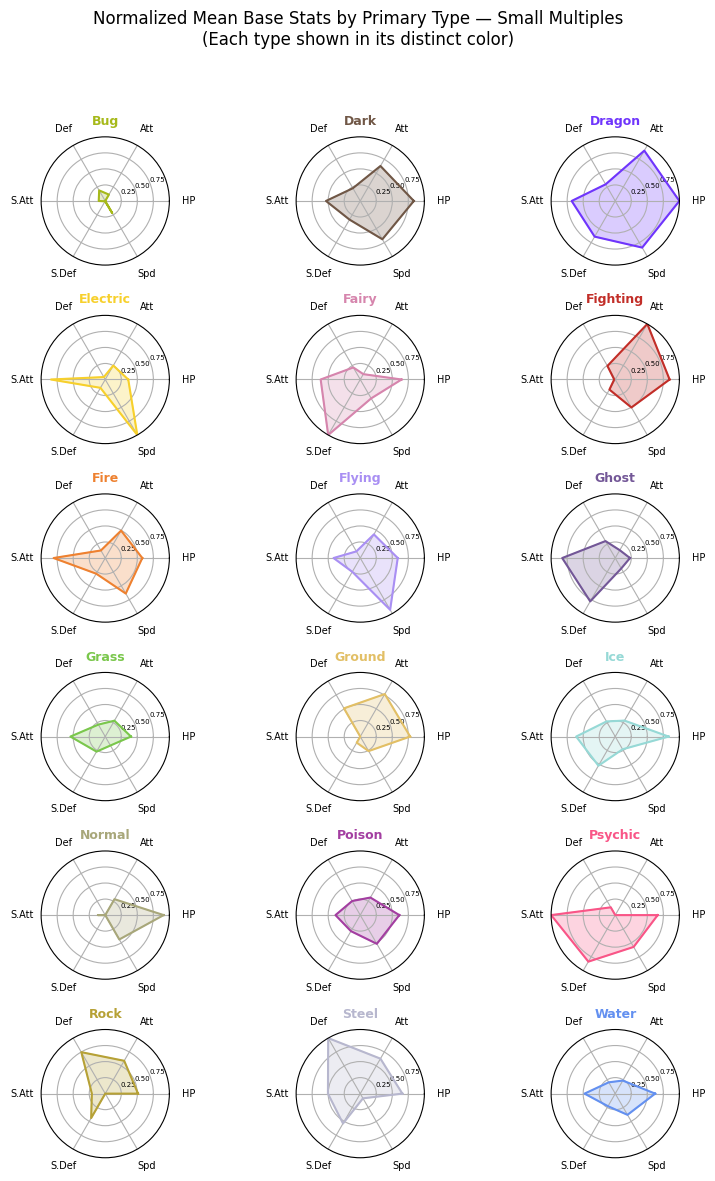

Small-multiples radar charts created for 18 Pokemon types
Each chart uses the distinct color associated with that Pokemon type


In [17]:
# Small-multiples radar charts: one radar per PrimaryType with distinct colors
# type_means_norm and stat_cols are expected from the previous cell
if 'type_means_norm' not in globals():
    stat_cols = ['HP','Att','Def','S.Att','S.Def','Spd']
    type_means = df_clean.groupby('PrimaryType')[stat_cols].mean().sort_index()
    type_means_norm = (type_means - type_means.min()) / (type_means.max() - type_means.min())

types = type_means_norm.index.tolist()
num_types = len(types)
cols = 3
rows = int(np.ceil(num_types / cols))

N = len(stat_cols)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Reduced figure size for more compact output
fig, axes = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(cols*2.6, max(2.2, rows*2.0)))
axes = axes.flatten()

for idx, t in enumerate(types):
    ax = axes[idx]
    values = type_means_norm.loc[t].tolist()
    values += values[:1]
    
    # Use the distinct color for this Pokemon type
    color = pokemon_type_colors.get(t, '#555555')
    
    ax.plot(angles, values, color=color, linewidth=1.5)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(t, fontsize=9, y=1.03, color=color, fontweight='bold')
    ax.set_ylim(0,1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stat_cols, fontsize=7)
    ax.set_yticks([0.25,0.5,0.75])
    ax.set_yticklabels(['0.25','0.50','0.75'], fontsize=5)

# Hide any unused subplots
for i in range(num_types, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Normalized Mean Base Stats by Primary Type — Small Multiples\n(Each type shown in its distinct color)', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Small-multiples radar charts created for {len(types)} Pokemon types")
print("Each chart uses the distinct color associated with that Pokemon type")

## Summary and Conclusions

### Key Findings:

**SeCo Framework Analysis:**
- Evaluated k values from 2 to 14 using randomized K-means sampling (see Technical Notes for parameters).
- SeCo balances two metrics: Separation (between-cluster sum-of-squares) and Concordance (median Cramér's V among top solutions).
- Based on the SeCo plot and scores, **k = 5** was selected as the recommended cluster count — it offers strong separation and high concordance compared with other tested k values.

**Dataset Insights:**
- Original dataset: 2,552 rows (multiple entries per Pokémon due to abilities/forms).
- **1,025 unique Pokémon** remain after deduplication (we keep the first entry per Name for clustering).
- **Features used**: 6 base stats — HP, Attack, Defense, Special Attack, Special Defense, Speed.
- **Types represented**: 18 primary types; consistent hex colors applied across visualizations.

**Final Clustering Results (k = 5):**
- Cluster distribution (k=5):
  - Cluster 0: 367 Pokémon (35.8%) — typically low-base-stat, early-evolution / common Pokémon.
  - Cluster 1: 213 Pokémon (20.8%) — fast, offensively-oriented Pokémon (high Speed / Attack).
  - Cluster 2: 161 Pokémon (15.7%) — special attackers with balanced defenses (high Special Attack / S.Def).
  - Cluster 3: 181 Pokémon (17.7%) — physical powerhouses (high HP / Attack).
  - Cluster 4: 103 Pokémon (10.0%) — defensive walls (high Defense / S.Def).

**Type-level observations (high-level):**
- Fire: skewed toward higher Attack and moderate Speed.
- Water: broadly balanced across stats (versatile roles).
- Grass: relatively strong defenses and special-attack tendencies for some species.
- Electric: notable for high Speed and good Special Attack.
- Psychic: elevated Special Attack and Special Defense on average.

### Practical Applications
- Inform game-balance and design decisions by identifying natural stat-role groupings.
- Assist competitive or casual players with team-building by highlighting role clusters (e.g., sweepers, tanks, walls).
- Provide a baseline for further analyses, such as generation- or region-specific clustering, or comparisons with other algorithms (DBSCAN, hierarchical).

The notebook artifacts (SeCo plot, cluster centers, radar charts) and the exported cluster membership table provide a reproducible basis for downstream analysis and visualization.

---

## Technical Notes

**Methodology:**
- **Preprocessing**: Kept one entry per Pokémon (deduplicated by Name) and standardized the six base-stat features using scikit-learn's `StandardScaler`.
- **SeCo Framework**: For each k in the tested range (2–14) we performed randomized K-means sampling with `kmsamples = 10,000` runs per k and selected the top `topsep = 100` solutions by Separation for concordance analysis (total K-means runs = 13 * 10,000 = 130,000).
- **Evaluation metrics**:
  - Separation: between-cluster sum-of-squares (Total SS - Within-cluster SS), higher is better for distinct clusters.
  - Concordance: median pairwise Cramér's V among the top solutions (measures solution stability / agreement).
- **Final selection**: k=5 was chosen based on a good trade-off of high Separation and high Concordance in the SeCo plot.
- **Visualization color system**: A deterministic mapping of Pokémon primary types to hex colors is applied to all type-level plots for consistent visual interpretation.

**Performance & reproducibility:**
- Typical SeCo runtime (full settings above): ~5–10 minutes on a modern multi-core CPU (actual time depends on available cores and parallelism settings).
- For faster iterations, reduce `kmsamples` to 1,000–2,000 or test a narrower k-range.
- Memory footprint for the clustering variables and intermediate label storage is modest (tens to low hundreds of MB depending on environment).
- Final deterministic K-means runs (for reporting and cluster export) used `random_state=42` to ensure reproducible assignments.

**Next steps / extensions:**
1. Include secondary types, abilities, generation/region as additional features or stratification factors.
2. Compare clusters to alternative algorithms (DBSCAN, hierarchical linkage) and evaluate external validity against generation/region labels.
3. Export cluster membership and visual assets for downstream reporting (CSV, PNG/SVG).

**Data source**: `data/pokemon_stats.csv` — 2,552 total rows in the raw file, yielding 1,025 unique Pokémon after deduplication.